<h1>Prepare Environment</h1>

In [18]:
from data_processing.Augmentation import *
from data_processing.helper import *

In [19]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
import time

<h1>Loading dataset</h1>

In [21]:
DATA_DIR = './CamVid/'

In [22]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [23]:
# Lets look at data we have
"""
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
"""
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'])

image, mask = dataset[5] # get some sample

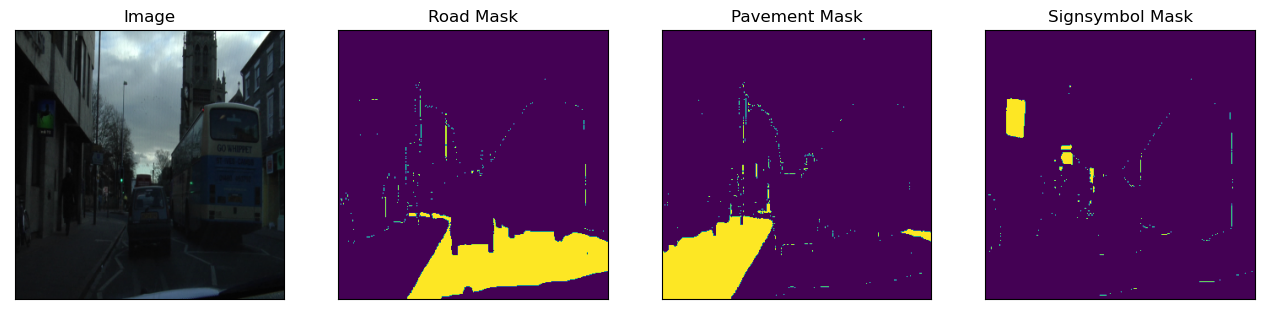

In [24]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

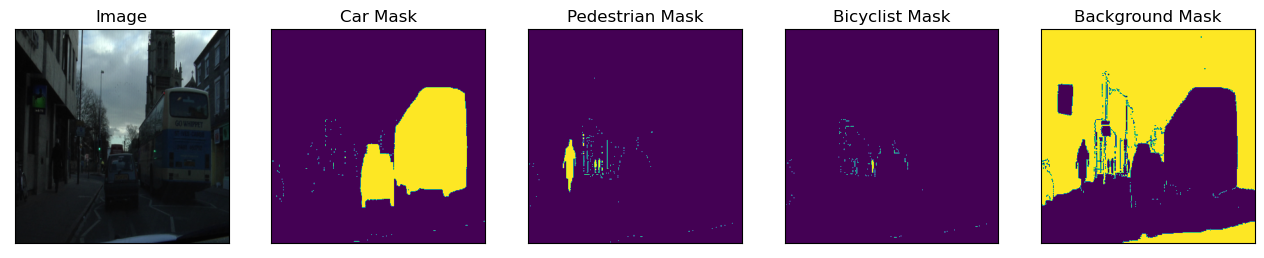

In [25]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Augmentation</h1>

In [26]:
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes = ['road', 'pavement', 'signsymbol','car', 
                             'pedestrian', 'bicyclist'], 
                  augmentation=get_training_augmentation())

In [27]:
image, mask = dataset[20] # get some sample

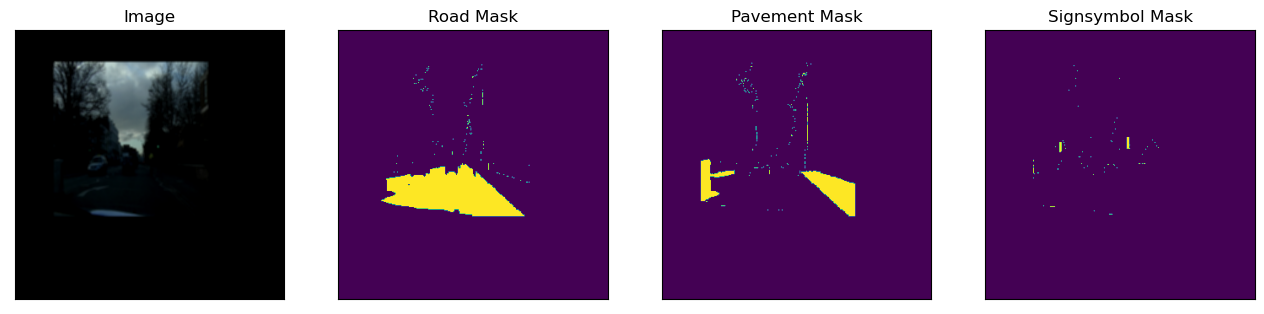

In [28]:
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pavement_mask=mask[..., 1].squeeze(),
    signsymbol_mask=mask[..., 2].squeeze(),
)

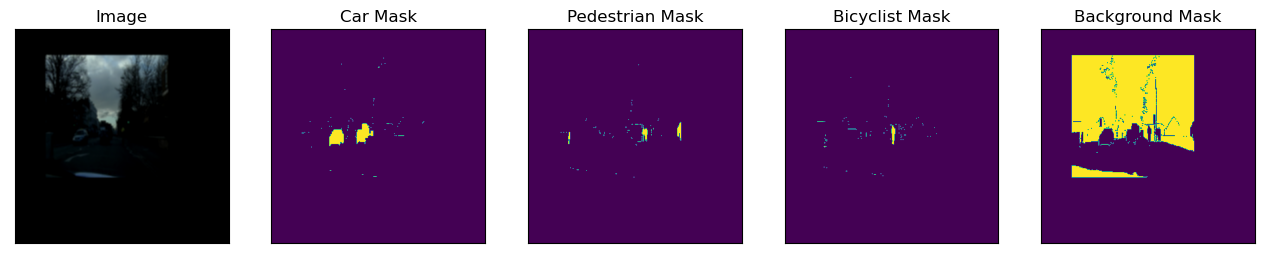

In [29]:
visualize(
    image=image, 
    car_mask=mask[..., 3].squeeze(),
    pedestrian_mask=mask[..., 4].squeeze(),
    bicyclist_mask=mask[..., 5].squeeze(),
    background_mask=mask[..., 6].squeeze(),
)

<h1>Segmentation Model Training</h1>

In [13]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [14]:
BACKBONE = 'inceptionv3'
BATCH_SIZE = 4
CLASSES = ['road', 'pavement', 'signsymbol','car', 'pedestrian', 'bicyclist']
LR = 0.0001

# Set number of epochs
EPOCHS = 250

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

87924736/87910968 [==============================] - 32s 0us/step


In [16]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3,4,5,6,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = total_loss, metrics = metrics)

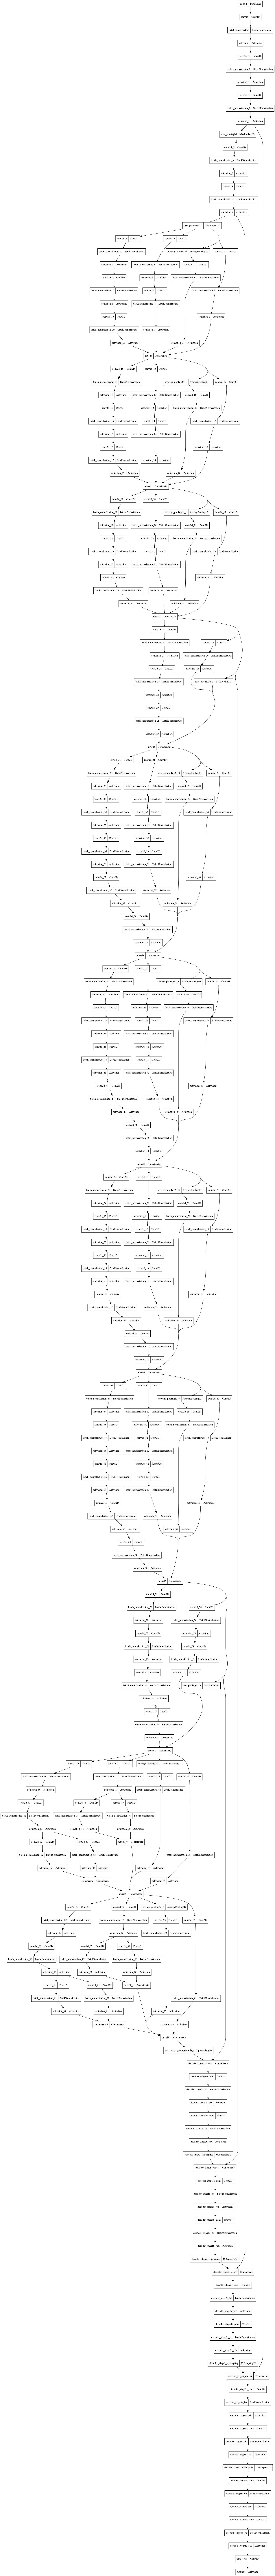

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [17]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint/mobilenetv2_Unet.h5', monitor='val_loss',save_weights_only=True, save_best_only=True, mode='min')
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1, factor=0.5, min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=STOPPING_PATIENCE, verbose=1, restore_best_weights=True)


In [19]:
# train model
pre_train = time.time()
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=[learning_rate,early_stopping,checkpoint], 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)
time_training = time.time() - pre_train

/home/waflol/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/250
91/91 [==============================] - 27s 218ms/step - loss: 0.8516 - iou_score: 0.1394 - f1-score: 0.1925 - val_loss: 0.7784 - val_iou_score: 0.2404 - val_f1-score: 0.2843
Epoch 2/250
91/91 [==============================] - 19s 204ms/step - loss: 0.7348 - iou_score: 0.2839 - f1-score: 0.3368 - val_loss: 0.7058 - val_iou_score: 0.3128 - val_f1-score: 0.3689
Epoch 3/250
91/91 [==============================] - 19s 204ms/step - loss: 0.6700 - iou_score: 0.3505 - f1-score: 0.4138 - val_loss: 0.6813 - val_iou_score: 0.3161 - val_f1-score: 0.3671
Epoch 4/250
91/91 [==============================] - 19s 204ms/step - loss: 0.6362 - iou_score: 0.3722 - f1-score: 0.4324 - val_loss: 0.5893 - val_iou_score: 0.3744 - val_f1-score: 0.4247
Epoch 5/250
91/91 [==============================] - 19s 211ms/step - loss: 0.6168 - iou_score: 0.3853 - f1-score: 0.4470 - val_loss: 0.6006 - val_iou_score: 0.3805 - val_f1-score: 0.4398
Epoch 6/250
91/91 [==============================] - 19s 206

Epoch 44/250
91/91 [==============================] - 19s 208ms/step - loss: 0.4514 - iou_score: 0.5322 - f1-score: 0.6135 - val_loss: 0.3741 - val_iou_score: 0.6078 - val_f1-score: 0.7140
Epoch 45/250
91/91 [==============================] - 19s 208ms/step - loss: 0.4587 - iou_score: 0.5239 - f1-score: 0.6067 - val_loss: 0.3793 - val_iou_score: 0.5932 - val_f1-score: 0.7011
Epoch 46/250
91/91 [==============================] - 19s 208ms/step - loss: 0.4522 - iou_score: 0.5307 - f1-score: 0.6128 - val_loss: 0.3790 - val_iou_score: 0.5942 - val_f1-score: 0.7018
Epoch 47/250
91/91 [==============================] - 19s 208ms/step - loss: 0.4479 - iou_score: 0.5353 - f1-score: 0.6178 - val_loss: 0.3648 - val_iou_score: 0.6046 - val_f1-score: 0.7111
Epoch 48/250
91/91 [==============================] - 19s 211ms/step - loss: 0.4488 - iou_score: 0.5331 - f1-score: 0.6166 - val_loss: 0.3656 - val_iou_score: 0.6011 - val_f1-score: 0.7088

Epoch 00048: ReduceLROnPlateau reducing learning rate 

Epoch 85/250
91/91 [==============================] - 19s 208ms/step - loss: 0.4222 - iou_score: 0.5452 - f1-score: 0.6312 - val_loss: 0.3503 - val_iou_score: 0.6119 - val_f1-score: 0.7172
Epoch 86/250
91/91 [==============================] - 19s 209ms/step - loss: 0.4171 - iou_score: 0.5484 - f1-score: 0.6348 - val_loss: 0.3492 - val_iou_score: 0.6130 - val_f1-score: 0.7181
Epoch 87/250
91/91 [==============================] - 19s 208ms/step - loss: 0.4150 - iou_score: 0.5499 - f1-score: 0.6354 - val_loss: 0.3494 - val_iou_score: 0.6130 - val_f1-score: 0.7181

Epoch 00087: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 88/250
91/91 [==============================] - 19s 209ms/step - loss: 0.4222 - iou_score: 0.5461 - f1-score: 0.6321 - val_loss: 0.3492 - val_iou_score: 0.6131 - val_f1-score: 0.7182
Epoch 89/250
91/91 [==============================] - 19s 208ms/step - loss: 0.4191 - iou_score: 0.5461 - f1-score: 0.6323 - val_loss: 0.3495 - val_iou_score: 0.61

<h1>Model Evaluation</h1>

In [20]:
print('Time training:{} (s)'.format(time_training))

Time training:1879.6747374534607 (s)


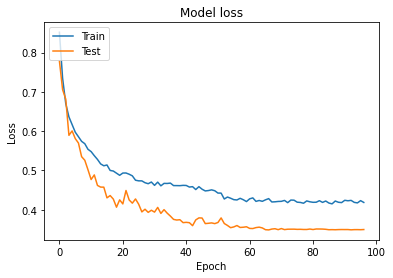

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

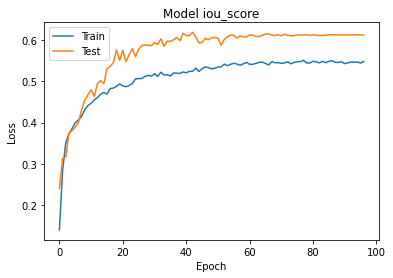

In [22]:
# Plot training & validation loss values
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [24]:
# load best weights
model.load_weights('./checkpoint/inceptionv3_Unet.h5')

In [25]:
scores  = model.evaluate_generator(test_dataloader)
print("Loss:{:.5}".format(scores[0]))
for metric,value in zip(metrics,scores[1:]):
    print("mean {}:{:.5}".format(metric.__name__,value))

/home/waflol/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss:0.45019
mean iou_score:0.51999
mean f1-score:0.59728


In [35]:
df = pd.DataFrame({'backbone':[BACKBONE],'model':['Unet'],'Time_training':[time_training],
                   'loss':[scores[0]],'Iou_score':[scores[1]]})

In [36]:
df

,backbone,model,Time_training,loss,Iou_score
0,mobilenetv2,Unet,1879.674737,0.450194,0.519989


In [37]:
data = pd.read_excel('Evaluation_model.xlsx')
data = data[['backbone','model','Time_training','loss','Iou_score']]
data

,backbone,model,Time_training,loss,Iou_score
0,efficientnetb3,Unet,2729.571379,0.430244,0.534888


In [38]:
df = pd.concat([df,data],axis=0)
df

,backbone,model,Time_training,loss,Iou_score
0,mobilenetv2,Unet,1879.674737,0.450194,0.519989
0,efficientnetb3,Unet,2729.571379,0.430244,0.534888


In [39]:
df.to_excel('Evaluation_model.xlsx')

<h1>Evaluation on Test</h1>

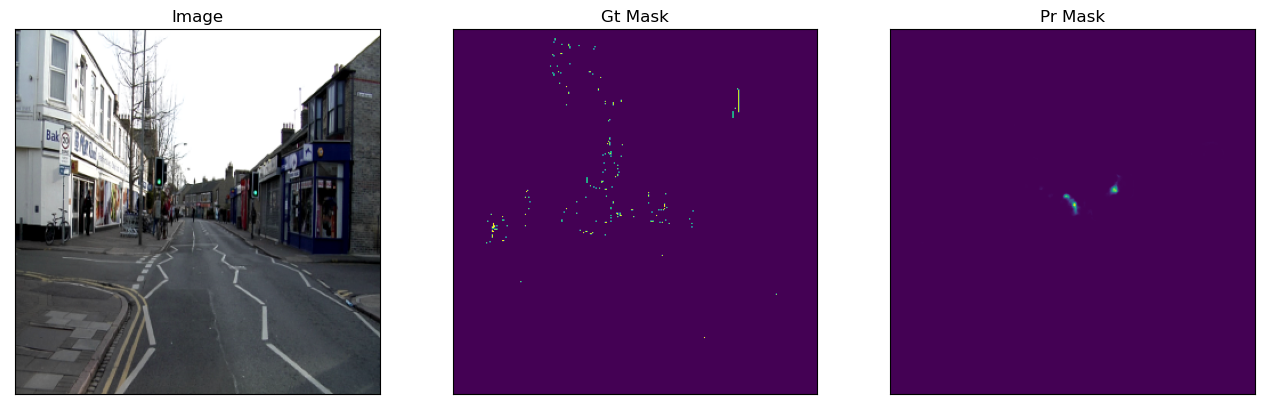

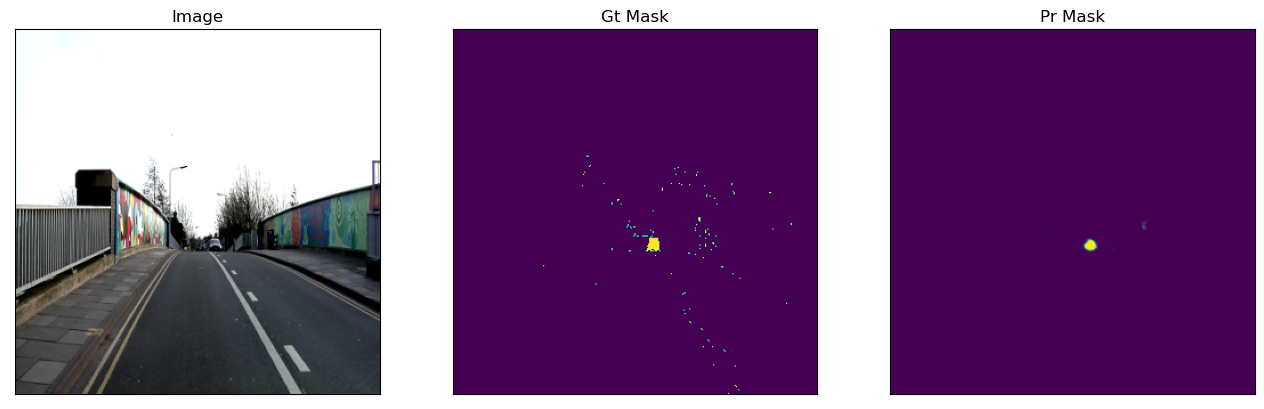

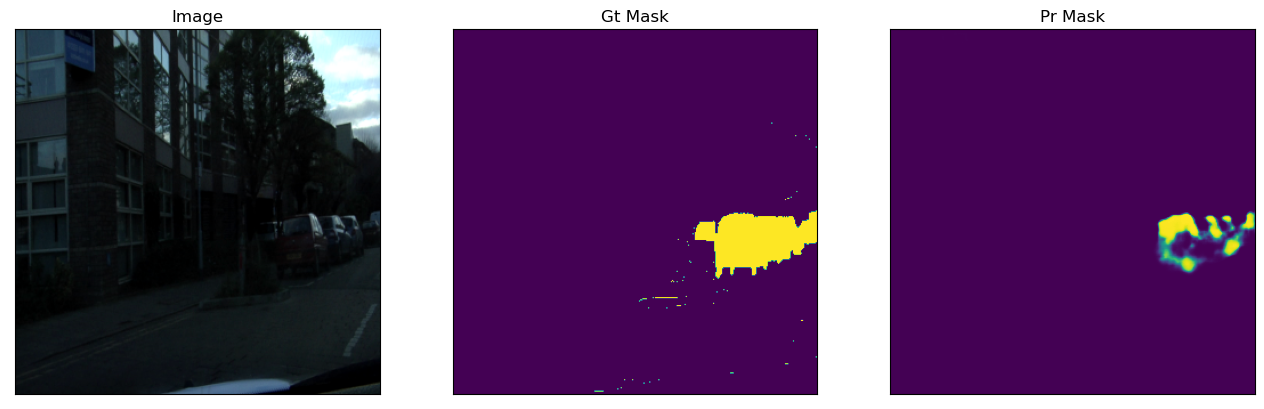

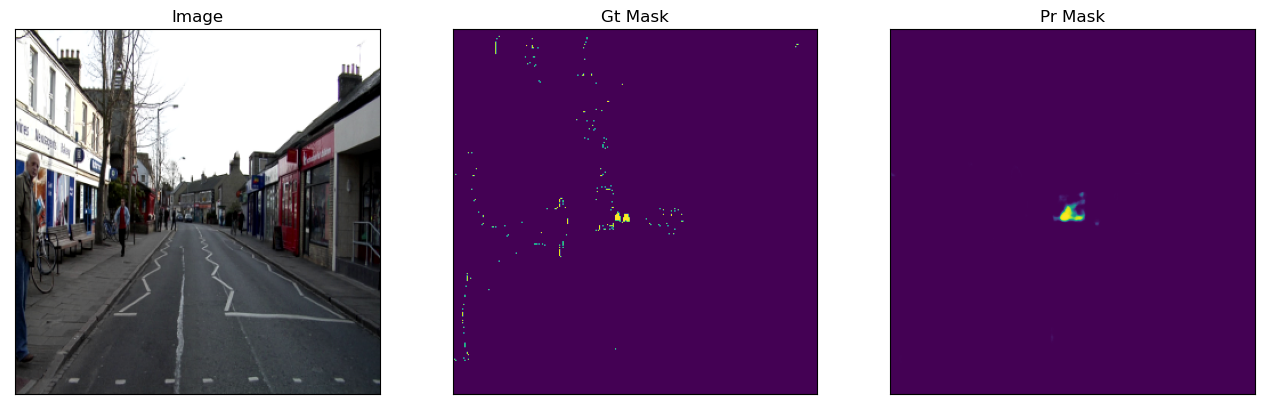

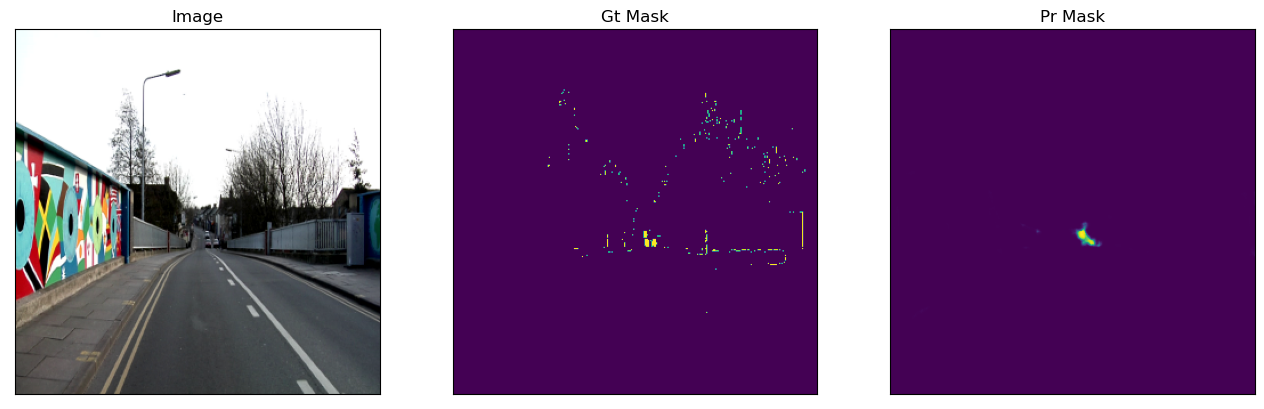

In [40]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,3].squeeze(),
        pr_mask=pr_mask[...,3].squeeze(),
    )